# The Heavy-Tail Phenomenon in hSGD

This notebook contains the code for reproducing the random features experiments reported in the paper. 

The current code handles the case where the step-size $\eta$, first eigenvalue of the training data and $\delta$ are varying.


In [2]:
# Required libraries are listed below. 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as scio
import math
from joblib import Parallel, delayed
from pandas import DataFrame
from time import time

import statsmodels.api as sm
from scipy.stats import t

In [3]:
# total number of data points 


n = 2000

# dimension
d = 200

# Synthetic Data Generation
sig_A = 1
sig_x = 3
sig_Y = 3

np.random.seed(1)

# explanatory vars.
A = sig_A * np.random.randn(n,d)

##normalization 
A = (A - A.min())/(A.max() - A.min())

# true regressor
x0 = sig_x * np.random.randn(d)

# responses
y = np.dot(A,x0) + sig_Y * np.random.randn(n)

# Mode of the distribution
x_star = np.dot(np.linalg.inv(np.dot(A.T,A)), np.dot(A.T,y))

np.random.seed()

In [4]:
#Singular value decomposition of training data A


P, E, QT = np.linalg.svd(A)

sv = E[0]
print(sv)


[INFO] Computing...
        done in 0.001 minutes
319.83131714104155


In [5]:
# Number of iteratios
K = 1000

#regularization
delta = 0

#learning rate
eta = 0.02

#batchaize
b=1



In [6]:
 """upper bound"""
h_1 = 2 *b*n* (sv**2  + n*delta) / (eta * sv**4)+1
print(h_1)

2.955185746221347


In [7]:
 """lower bound"""
Lam = np.dot(E.T, E)
h_2 = 1 + 2 *b*n* (sv**2 + n*delta) / (eta * sv**4)+1 - Lam/sv**2
print(h_2)

2.9089065027387946


In [8]:
(2 *b*n* (sv**2 + n*delta))/(sv**2 * Lam) # >learning rate

0.03737407118416092

In [9]:
# Loss function
def loss_fn(x,A,y,nsamp,delta):
    res = np.sum((np.dot(A,x) - y)**2)/(2*nsamp) + (delta*np.dot(x,x))/2
    return res

In [10]:
def sgd_linreg(A,Y,n,d,K,eta,b,delta,compute_loss = False,plot_loss= False):
    
    loss_sgd = np.zeros(K)

    x_cur = 0.5 * np.random.randn(d)
    
    
    if(compute_loss is True):
        loss_sgd[0] = loss_fn(x_cur,A,Y,n,delta)

    for k in range(1,K):
        ix = np.random.permutation(n)
        S_k = ix[0:int(b)]
        A_k = A[S_k,:]
        y_k = Y[S_k]
        
        grad = np.dot(A_k.T, np.dot(A_k,x_cur)) - np.dot(A_k.T, y_k) -delta*x_cur
        grad = grad / b
        x_cur = x_cur - eta * grad
        

        if(compute_loss is True):
            loss_sgd[k] = loss_fn(x_cur,A,Y,n,delta)

    x_final = x_cur 
    
    if(plot_loss is True):
        plt.figure()
        plt.semilogy(loss_sgd)
        #plt.plot(loss_sgd)

        
    return x_final

In [20]:
### main result

print("[INFO] SGD interation...")
t0 = time()

# Numer of repetitions

numRep = 1000

x_fn = np.zeros((d,numRep))
loss = np.zeros((K,numRep))

tmp_res = Parallel(n_jobs=10)(delayed(sgd_linreg)(A,y,n,d,K,eta,b,delta,compute_loss= True) for i in range(numRep))
tmp_res = np.array(tmp_res,dtype = object)
        

print("        done in %0.3f minutes" % ((time() - t0)/60))


[INFO] SGD interation...
        done in 0.514 minutes


In [21]:
Y = np.dot(QT, tmp_res.T)
Z = Y[0,:]
Z = Z - np.average(Z)
Z = Z.astype('float64')

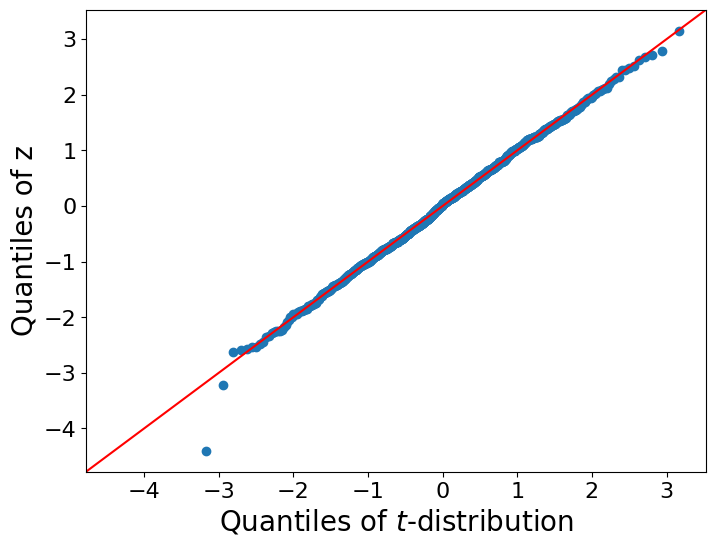

In [22]:
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(1,1)
sm.qqplot(Z, t,fit=True,line="45", ax = axs)

axs.set_xlabel('Quantiles of $t$-distribution', fontsize = 20)
axs.set_ylabel('Quantiles of z', fontsize = 20)
axs.tick_params(labelsize = 16)

plt.show()